参考链接：https://github.com/benmoseley/harmonic-oscillator-pinn/tree/main

以及：
https://github.com/benmoseley/scalable-pinns-workshop

code a PINN form scratch in PyTorch

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def exact_solution(d, w0, t):
    """defines the analytical solution to the uder-damped harmonic oscillator problem"""
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(w * t + phi)
    exp = torch.exp(-d * t)
    u = exp*2*A*cos
    return u


class FCN(nn.Module):
    """Defines a fully connected neural network"""

    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden_layers):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_hidden_layers = num_hidden_layers
        self.layer = []
        self.layer.append(nn.Linear(input_dim, hidden_dim))
        self.layer.append(nn.Tanh())
        for i in range(num_hidden_layers):
            self.layer.append(nn.Linear(hidden_dim, hidden_dim))
            self.layer.append(nn.Tanh())
        self.layer.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*self.layer)

    def forward(self, x):
        return self.model(x)

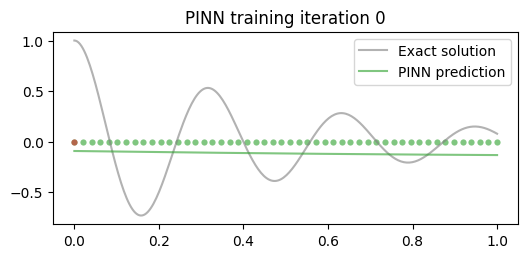

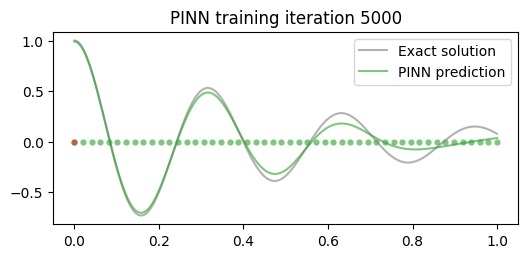

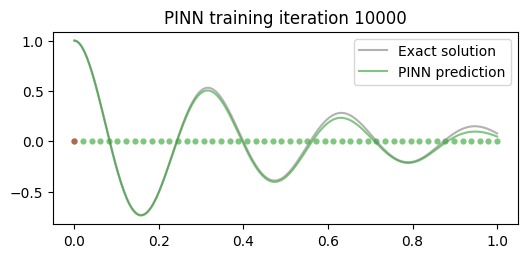

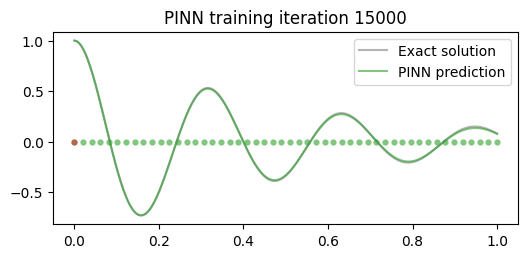

In [8]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(input_dim=1, output_dim=1, hidden_dim=32, num_hidden_layers=3)

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(15001):
    optimizer.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1, lambda2 = 1e-1, 1e-4

    # compute the boundary loss
    u = pinn(t_boundary)  # [1, 1]
    loss1 = (torch.squeeze(u) - 1)**2

    dudt = torch.autograd.grad(u, t_boundary, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute the physics loss
    u = pinn(t_physics)  # [30, 1]
    dudt = torch.autograd.grad(u, t_physics, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, grad_outputs=torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # compute the total loss
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3

    # backpropagate and update the weights
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if i % 5000 == 0:
        u_pred = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:, 0], torch.zeros_like(t_physics)[:, 0], s=20, lw=0,color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0], torch.zeros_like(t_boundary)[:, 0], s=20, lw=0,color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:, 0], label="Exact solution", color='tab:grey', alpha=0.6)
        plt.plot(t_test[:,0], u_pred[:, 0], label="PINN prediction", color='tab:green', alpha=0.6)
        plt.title(f"PINN training iteration {i}")
        plt.legend()
        plt.show()

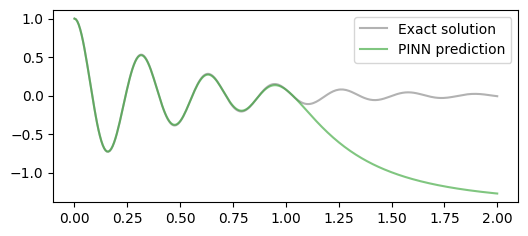

In [9]:
# 测试一下更长的时间
t_eval = torch.linspace(0, 2, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_eval)
u_pred = pinn(t_eval).detach()
plt.figure(figsize=(6,2.5))
plt.plot(t_eval[:,0], u_exact[:, 0], label="Exact solution", color='tab:grey', alpha=0.6)
plt.plot(t_eval[:,0], u_pred[:, 0], label="PINN prediction", color='tab:green', alpha=0.6)
plt.legend()
plt.show()

# 测试发现，这个pinn还是在采样区域拟合的很好，对于外推效果不好

# train a PINN to invert for underlying parameters

inputs: noisy observations of the oscillator's displacement

outputs: estimate $\mu$, the coefficient of friction


The key idea is to also treat $\mu$ as `learnable parameter` when traning the PINN

True value of mu: 4


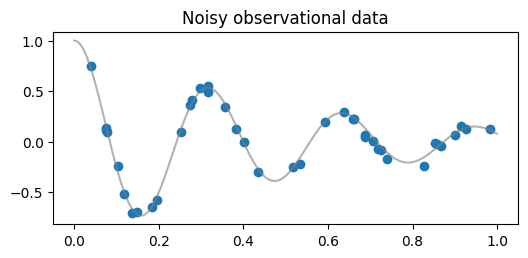

In [16]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

plt.figure(figsize=(6,2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

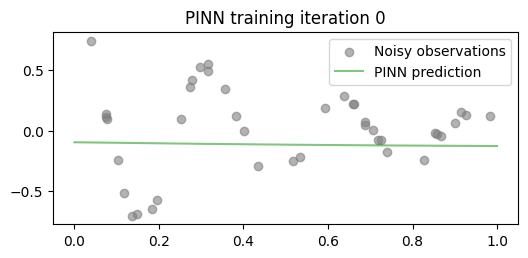

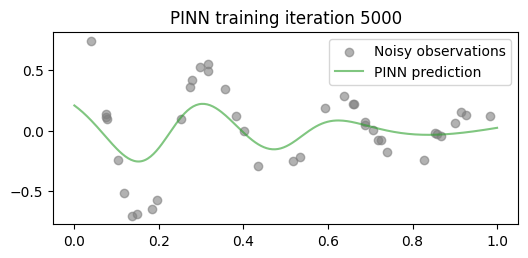

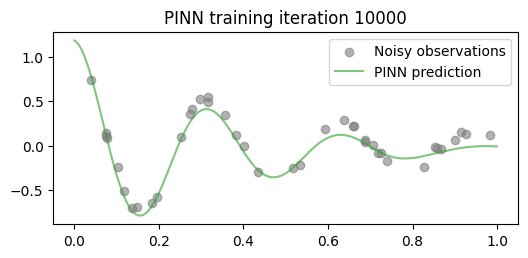

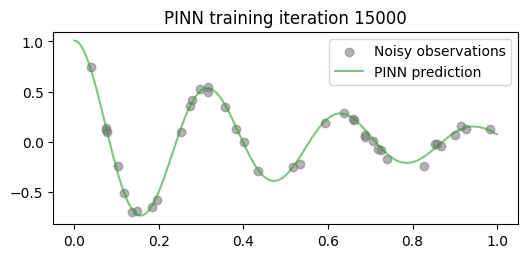

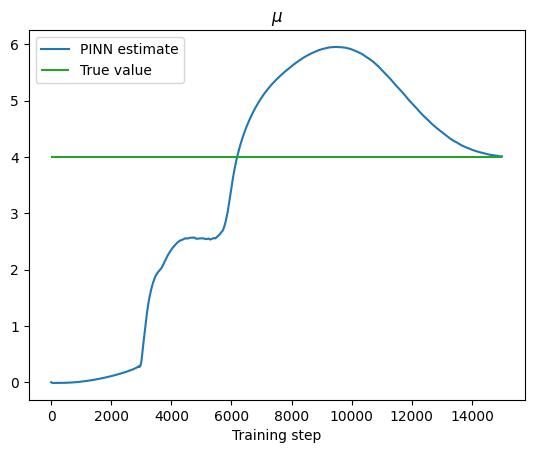

In [21]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(input_dim=1, output_dim=1, hidden_dim=32, num_hidden_layers=3)


# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2
mus = []
# treat mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))

optimizer = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=1e-3)
for i in range(15001):
    optimizer.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1 = 1e4

    # compute the physics loss
    u = pinn(t_physics)  # [30, 1]
    dudt = torch.autograd.grad(u, t_physics, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, grad_outputs=torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # compute data loss
    u = pinn(t_obs)  # [30, 1]
    loss2 = torch.mean((u - u_obs)**2)

    # compute the total loss
    loss = loss1 + lambda1 * loss2

    # backpropagate and update the weights
    loss.backward()
    optimizer.step()

    # record mu value
    mus.append(mu.item())

    # plot the result as training progresses
    if i % 5000 == 0:
        u_pred = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:, 0], label="Noisy observations", color='tab:grey', alpha=0.6)
        plt.plot(t_test[:,0], u_pred[:, 0], label="PINN prediction", color='tab:green', alpha=0.6)
        plt.title(f"PINN training iteration {i}")
        plt.legend()
        plt.show()


plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", colors="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()